# R from Q

- This notebook shows how to obtain the radius of interaction from the value of the charge measured at the SiPMs

In [1]:
import Pkg

In [482]:
Pkg.add.(["HTTP", "Plots", "DataFrames", "HDF5","DrWatson", "StatsBase"]);

In [504]:
Pkg.add.(["Test"]);

In [48]:
Pkg.add.(["VegaLite","VegaDatasets"]);

In [129]:
Pkg.add.(["LsqFit","GLM"])

2-element Vector{Nothing}:
 nothing
 nothing

In [130]:
using LsqFit
using GLM

In [10]:
using HTTP
using Plots
using VegaLite
using VegaDatasets
using DataFrames
using HDF5
using DrWatson
using Test

In [11]:
using Glob
using CSV

In [12]:
using Statistics
using StatsBase
using Printf

In [13]:
@quickactivate "JPetalo"

In [14]:
pwd()

"/Users/jj/JuliaProjects/JPetalo/notebooks"

In [15]:
datadir()

"/Users/jj/JuliaProjects/JPetalo/data"

In [16]:
srcdir()

"/Users/jj/JuliaProjects/JPetalo/src"

In [459]:
include(srcdir("jpetalo.jl"))

Main.JPetalo

## Read a summary data frame with photoelectric interactions

In [285]:
drx = datadir("nema3df")
input = string(drx,"/nema3df_f10_q4_phot.csv")
n3df = DataFrame(CSV.File(input));

In [286]:
println(names(n3df))

["dz", "nsipm", "phistd", "q1", "q2", "qav", "qmx", "r", "xr1", "xr2", "xt1", "xt2", "yr1", "yr2", "yt1", "yt2", "zr1", "zr2", "zstd", "zt1", "zt2"]


## Dependence of energy with radius of interaction

#### Raw histogram
- Histograming the energy deposited in the SiPMs yields a wide and non gaussian distribution

In [287]:
hq, phq = JPetalo.hist1d(n3df.q1, 50, "q (pes)");

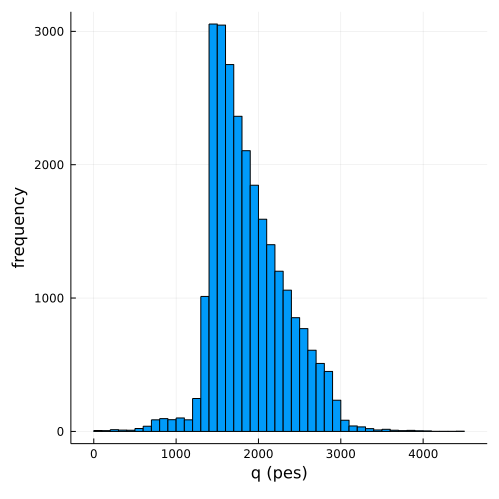

In [288]:
plot(phq,  layout = (1, 1), size = (500, 500), 
     legend=false, fmt = :png)

#### To compute the dependence with R, first cut tails.

In [453]:
n3dfq = JPetalo.select_by_column_value_interval(n3df, "q1", 1000.0, 3000.0);

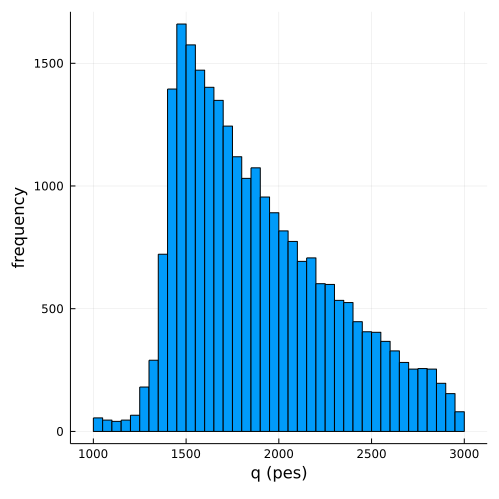

In [454]:
hq, phq = JPetalo.hist1d(n3dfq.q1, 50, "q (pes)");
plot(phq,  layout = (1, 1), size = (500, 500), 
     legend=false, fmt = :png)

#### Dependence of energy with the radius at which the gamma interacts

In [455]:
xe,ye,h,hm = JPetalo.hist2d(n3dfq.r,n3dfq.q1, 250, "r (mm)", "q (pes)");

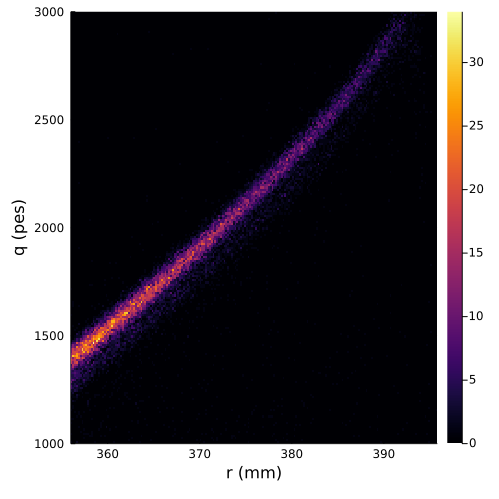

In [456]:
plot(hm,  layout = (1, 1), size = (500, 500), 
     legend=false, fmt = :png)

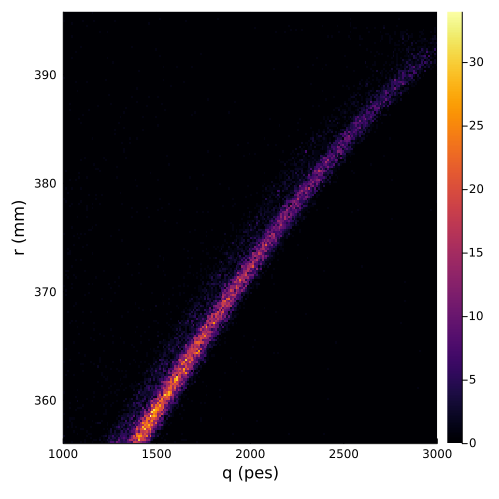

In [457]:
xe,ye,h,hm = JPetalo.hist2d(n3dfq.q1, n3dfq.r, 250,  "q (pes)", "r (mm)");
plot(hm,  layout = (1, 1), size = (500, 500), 
     legend=false, fmt = :png)

In [460]:
pqrdf = JPetalo.p1df(n3dfq.q1, n3dfq.r, 100);

In [461]:
lfqr, pqr, cqr = JPetalo.lfit(pqrdf);

In [462]:
cqr

2-element Vector{Float64}:
 340.6261677563251
   0.016796253902272636

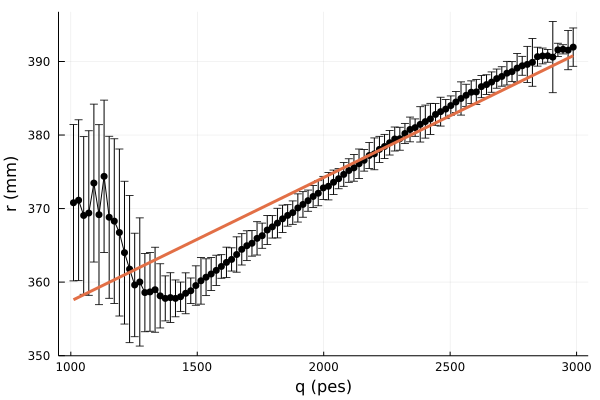

In [463]:
plot(pqrdf.x_mean,pqrdf.y_mean, yerror=pqrdf.y_std, shape = :circle, color = :black, legend=false)
plot!(pqrdf.x_mean,lfqr, lw=3, legend=false)
ylabel!("r (mm)")
xlabel!("q (pes)")

#### The plot shows that values below 1400 pes are useless

In [509]:
n3dfq = JPetalo.select_by_column_value_interval(n3df, "q1", 1400.0, 3000.0);

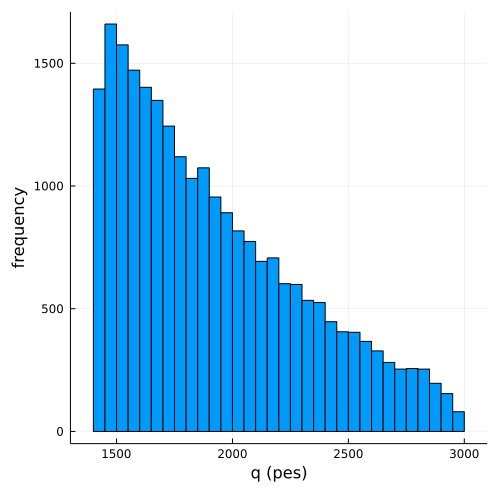

In [510]:
hq, phq = JPetalo.hist1d(n3dfq.q1, 50, "q (pes)");
plot(phq,  layout = (1, 1), size = (500, 500), 
     legend=false, fmt = :png)

In [511]:
pqrdf = JPetalo.p1df(n3dfq.q1, n3dfq.r, 100);

In [512]:
lfqr, pqr, cqr = JPetalo.lfit(pqrdf);

In [513]:
cqr

2-element Vector{Float64}:
 326.8651817332921
   0.022586731900620417

In [ ]:
function grfq(q)
    return 326.9 + 0.0226 * q
end
rfq(q::Float32) = grfq(q)
rfq(q::Float64) = grfq(q)

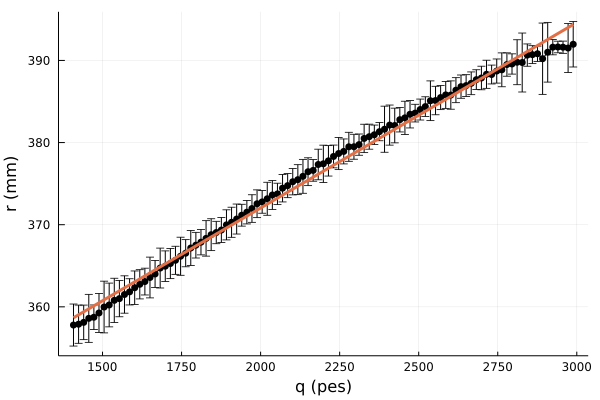

In [514]:
plot(pqrdf.x_mean,pqrdf.y_mean, yerror=pqrdf.y_std, shape = :circle, color = :black, legend=false)
plot!(pqrdf.x_mean,lfqr, lw=3, legend=false)
ylabel!("r (mm)")
xlabel!("q (pes)")

#### Although the data is not fully lineal the fit is acceptable

#### Trying cuadratic and cubic functions

In [500]:
@. xmodel1(x, p) = p[1]+ x*p[2]
@. xmodel2(x, p) = p[1]+ x*p[2] * x^2*p[3]
@. xmodel3(x, p) = p[1]+ x*p[2] * x^2*p[3] + x^3*p[4]

xmodel3 (generic function with 1 method)

In [502]:
p1 = [cqr[1], cqr[2]]
p2 = [cqr[1], cqr[2], 1.0]
p3 = [cqr[1], cqr[2], 1.0, 1.0]

4-element Vector{Float64}:
 326.8651817332921
   0.022586731900620417
   1.0
   1.0

In [504]:
function nlmodel(model, p0, df)
    fq = curve_fit(model, df.x_mean, df.y_mean, p0)
    return coef(fq), stderror(fq)
    
end

nlmodel (generic function with 2 methods)

In [505]:
nlmodel(xmodel1, p1, pqrdf)

([326.8651817332921, 0.022586731900620417], [0.42423963745289067, 0.0001888707748978904])

In [506]:
nlmodel(xmodel2, p2, pqrdf)

([359.1160502406427, 5.756387632303743e-6, 0.00025141110904063367], [0.5490668769404629, 3.0369954685207023e6, 1.3264124094203809e8])

In [507]:
nlmodel(xmodel3, p3, pqrdf)

([-2.9572105420642056e9, -2.3049760591910598e-6, -0.00010205001581082543, 0.7370624867746017], [1.6145046697022498e9, 1.7903968132266487e10, 2.017562395322816e10, 1.8281735027771671e6])

#### Linear model is OK, cuadratic and cubic do not represent the data (errors)

### corrected q

In [508]:
prqdf = JPetalo.p1df(n3dfq.r, n3dfq.q1, 100);

In [515]:
lfrq, prq, crq = JPetalo.lfit(prqdf);

In [516]:
qc = JPetalo.qcor(prqdf,lfrq, 2000.);

In [517]:
crq

2-element Vector{Float64}:
 -12301.059957883765
     38.41697039129139

In [518]:
function rfromq(crq)
    return x -> (1.0/crq[2])* (x-crq[1])
end

rfromq (generic function with 1 method)

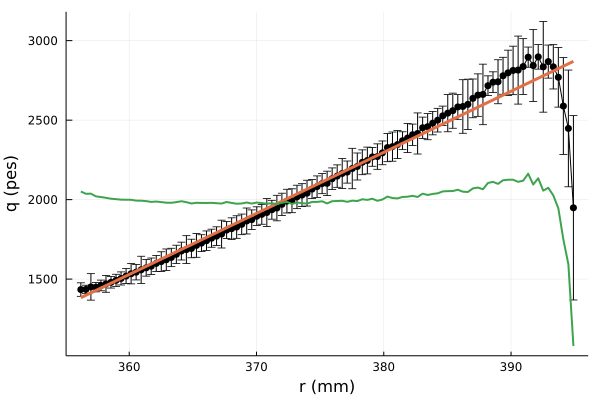

In [519]:
plot(prqdf.x_mean,prqdf.y_mean, yerror=prqdf.y_std, shape = :circle, color = :black, legend=false)
plot!(prqdf.x_mean,lfrq, lw=3, legend=false)
plot!(prqdf.x_mean,qc, lw=2, legend=false)
xlabel!("r (mm)")
ylabel!("q (pes)")

#### Plot shows that for larger values of R (larger values of q) linear relation does not hold either. 

In [534]:
function lf2(x)
    return crq[1] + crq[2] *x
end

lf2 (generic function with 1 method)

In [535]:
JPetalo.qcor2!(n3df, lf2, "r", "q1", "qc", 2000.0);

In [536]:
println(names(n3df))

["dz", "nsipm", "phistd", "q1", "q2", "qav", "qmx", "r", "xr1", "xr2", "xt1", "xt2", "yr1", "yr2", "yt1", "yt2", "zr1", "zr2", "zstd", "zt1", "zt2", "qc"]


In [537]:
x,y,h,hm = JPetalo.hist2d(n3df.r,n3df.qc, 250, "r (mm)", "q (pes)");

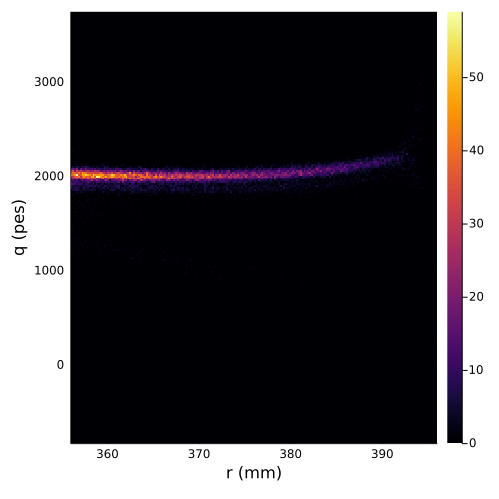

In [538]:
plot(hm,  layout = (1, 1), size = (500, 500), 
     legend=false, fmt = :png)

#### Energy corrected

In [539]:
hqc, phqc = JPetalo.hist1d(n3df.qc, 50, "q(pes)");

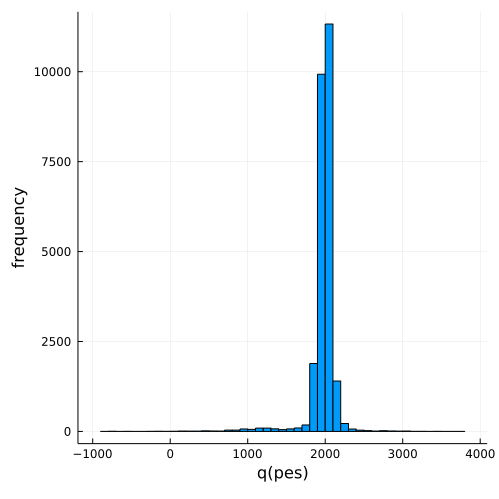

In [540]:
plot(phqc,  layout = (1, 1), size = (500, 500), 
     legend=false, fmt = :png)